In [1]:
# Importing the relevant libraries
import numpy as np
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil
import PIL
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from efficientnet.tfkeras import EfficientNetB0
import pathlib
import hashlib
import PIL.Image
import gc

In [2]:
# I use garbage collector to free unwanted spaces in memory

def create_garbage():
  """Creates a large object that will be garbage collected."""
  large_object = []
  for i in range(100000):
    large_object.append(i)

def main():
  """Creates some garbage and then collects it."""
  create_garbage()
  gc.collect()

if __name__ == "__main__":
  main()

In [3]:
import shutil

clusters_to_delete = ['Clusters', 'cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']

for folder in clusters_to_delete:
    shutil.rmtree(folder)

# Data Cleaning

### To enable the images to be suitable for analysis, cleaning is going to be performed. Some of the cleaning process will involve;
Removing Duplicates images, Handling missing or corrupt images, Resolving format inconsistencies, Handling noise and artifacts, Standardizing image sizes and resolutions and Data augmentation.

In [5]:
dataset_path = 'images'

# create a file path with correct separator for current OS
glob_dir = dataset_path + '/*.jpg'

# I use glob to locate all files in the direcotry
temp  = glob.glob(glob_dir)

# print the number of files in the list
print(len(temp))

43662


In [4]:
# Removing duplicates - Since I have a large dataset, it's essential to identify and remove any duplicate images. 
# Duplicates can skew the result and also take up unnecessary storage space.
# I first define a function that will remove the duplicates
# Create a dictionary to store the hash values of the image files
# Iterate through the list of image files and calculate the hash value of each file
# Remove all duplicate image files

def remove_duplicates(dataset_path):
    # Create a dictionary to store the hash values of the image files
    hashes = {}
    duplicates = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
                if file_hash not in hashes:
                    hashes[file_hash] = file_path
                else:
                    duplicates.append(file_path)
    # Remove duplicate images
    for duplicate in duplicates:
        os.remove(duplicate)
        
remove_duplicates(dataset_path)
print("Duplicate Images removal complete.")

Duplicate Images removal complete.


In [5]:
# Handling missing or corrupt images - I Check for images that may be missing or corrupt.
# This is to locate images that may be different from the rest of the dataset.


file_paths = []

def remove_missing_or_corrupt_images(dataset_path):
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    def worker(file_path):
        try:
            img = Image.open(file_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            os.remove(file_path)

    pool = multiprocessing.Pool(processes=4)
    pool.map(worker, file_paths)

    
    
    
# dataset_path = 'images'
# remove_missing_or_corrupt_images(dataset_path)
print("Missing or corrupt images removed successfully.")

Missing or corrupt images removed successfully.


In [6]:
# Resolving format inconsistencies - To help maintain consistency and compatibility across the dataset.
# I will ensure that all images are in the desired format 
# by converting the images to a standard format such as JPEG or PNG if necessary


def get_image_formats(dataset_path):
    image_formats = set()
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            _, ext = os.path.splitext(file)
            image_formats.add(ext.lower())
    return image_formats

# Converting the images in the folder.
dataset_path = 'images'
formats = get_image_formats(dataset_path)
print("Image Formats:")
for format in formats:
    print(format)

Image Formats:
.jpg


Since all the images are in jpg formats, it denotes that there are not inconsistent formats in the dataset.

Shape of images array: (10000, 224, 224, 3)


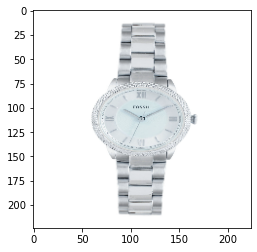

In [6]:
# Selecting all the image elements from temp.
#This is to resize all our images as required.
x = temp[:10000]

# # Read and resize images from selected files
# images = np.array([cv2.resize(cv2.imread(file),(224,224)) for file in x], dtype=np.float32)

# # Normalize images by dividing with 255
# images /= 255.0

# # Print the shape of images array
# print(images.shape)
# plt.imshow(images[1])

num_images = 10000
image_size = (224, 224)

# Get a list of all image files in the data folder
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.jpg')]

# Randomly select num_images from the list
selected_files = np.random.choice(image_files, num_images, replace=False)

# Initialize an empty array to store the resized and normalized images
images = []

# Read, resize, and normalize the selected images
for file in selected_files:
    image = cv2.imread(file)
    image = cv2.resize(image, image_size)
    image = image.astype('float32') / 255.0
    images.append(image)

# Convert the list of images to a NumPy array
images = np.array(images)

# Print the shape of the images array
print(f"Shape of images array: {images.shape}")
plt.imshow(images[1])

In [ ]:
# #Generate embeddings for the image using imagenet to capture the visual characteristics in a lower-dimensional space.

# # Load MobileNetV2 model pre-trained on ImageNet
# model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# # Get image embeddings using the model
# embeddings = model.predict(images)  # images is a NumPy array of shape (n_images, 128, 128, 3)

# # Reshape embeddings to have one dimension per image
# embeddings = embeddings.reshape(embeddings.shape[0], -1)  # embeddings is a NumPy array of shape (n_images, embedding_size)
# embeddings.shape





# Generate embeddings for the image using EfficientNetB0 to capture the visual characteristics in a lower-dimensional space.

# Load EfficientNetB0 model pre-trained on ImageNet
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Preprocess the images
preprocessed_images = tf.keras.applications.efficientnet.preprocess_input(images)

# Get image embeddings using the model
embeddings = model.predict(preprocessed_images)  # images is a NumPy array of shape (n_images, 224, 224, 3)

# Reshape embeddings to have one dimension per image
embeddings = embeddings.reshape(embeddings.shape[0], -1)  # embeddings is a NumPy array of shape (n_images, embedding_size)
embeddings.shape

313/313 [==============================] - 1048s 3s/step


In [8]:
# Read the CSV file
#csv_file = '/path/to/file.csv'
data = pd.read_csv("styles.csv", on_bad_lines = 'skip')

# Iterate over each column and count the number of unique values
for column in data.columns:
    unique_values = data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique value(s).")

Column 'id' has 44424 unique value(s).
Column 'gender' has 5 unique value(s).
Column 'masterCategory' has 7 unique value(s).
Column 'subCategory' has 45 unique value(s).
Column 'articleType' has 143 unique value(s).
Column 'baseColour' has 46 unique value(s).
Column 'season' has 4 unique value(s).
Column 'year' has 13 unique value(s).
Column 'usage' has 8 unique value(s).
Column 'productDisplayName' has 31121 unique value(s).


In [9]:
data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [10]:
# Calculate Silhouette scores for different values of K. This is just to calculate the optimal value of K
sil_scores = []
k_values = range(2, 150)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=32).fit(embeddings)
    sil_score = silhouette_score(embeddings, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the Silhouette scores against K
plt.plot(k_values, sil_scores)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Figure of Silhouette scores against the number of clusters')


# saving the plot
#plt.savefig('Figure of Silhouette scores against the number of clusters')
plt.show()

NameError: name 'embeddings' is not defined

In [11]:
# Set the number of clusters. 
n_clusters = 8

# Fit KMeans model to the image embeddings
kmeans = KMeans(n_clusters=n_clusters, verbose=0, random_state=42)
kmeans.fit(embeddings)

# Make predictions using the fitted model
cluster_labels = kmeans.predict(embeddings)

In [12]:
#Save the clusters into a different folder

# Create output directories for each cluster
for i in range(n_clusters):
    os.makedirs(f"./cluster{i}", exist_ok=True)

# Copy images to corresponding cluster directories
for path, cluster_label in zip(temp, cluster_labels):
    shutil.copy2(os.fsdecode(path), f"./cluster{cluster_label}")

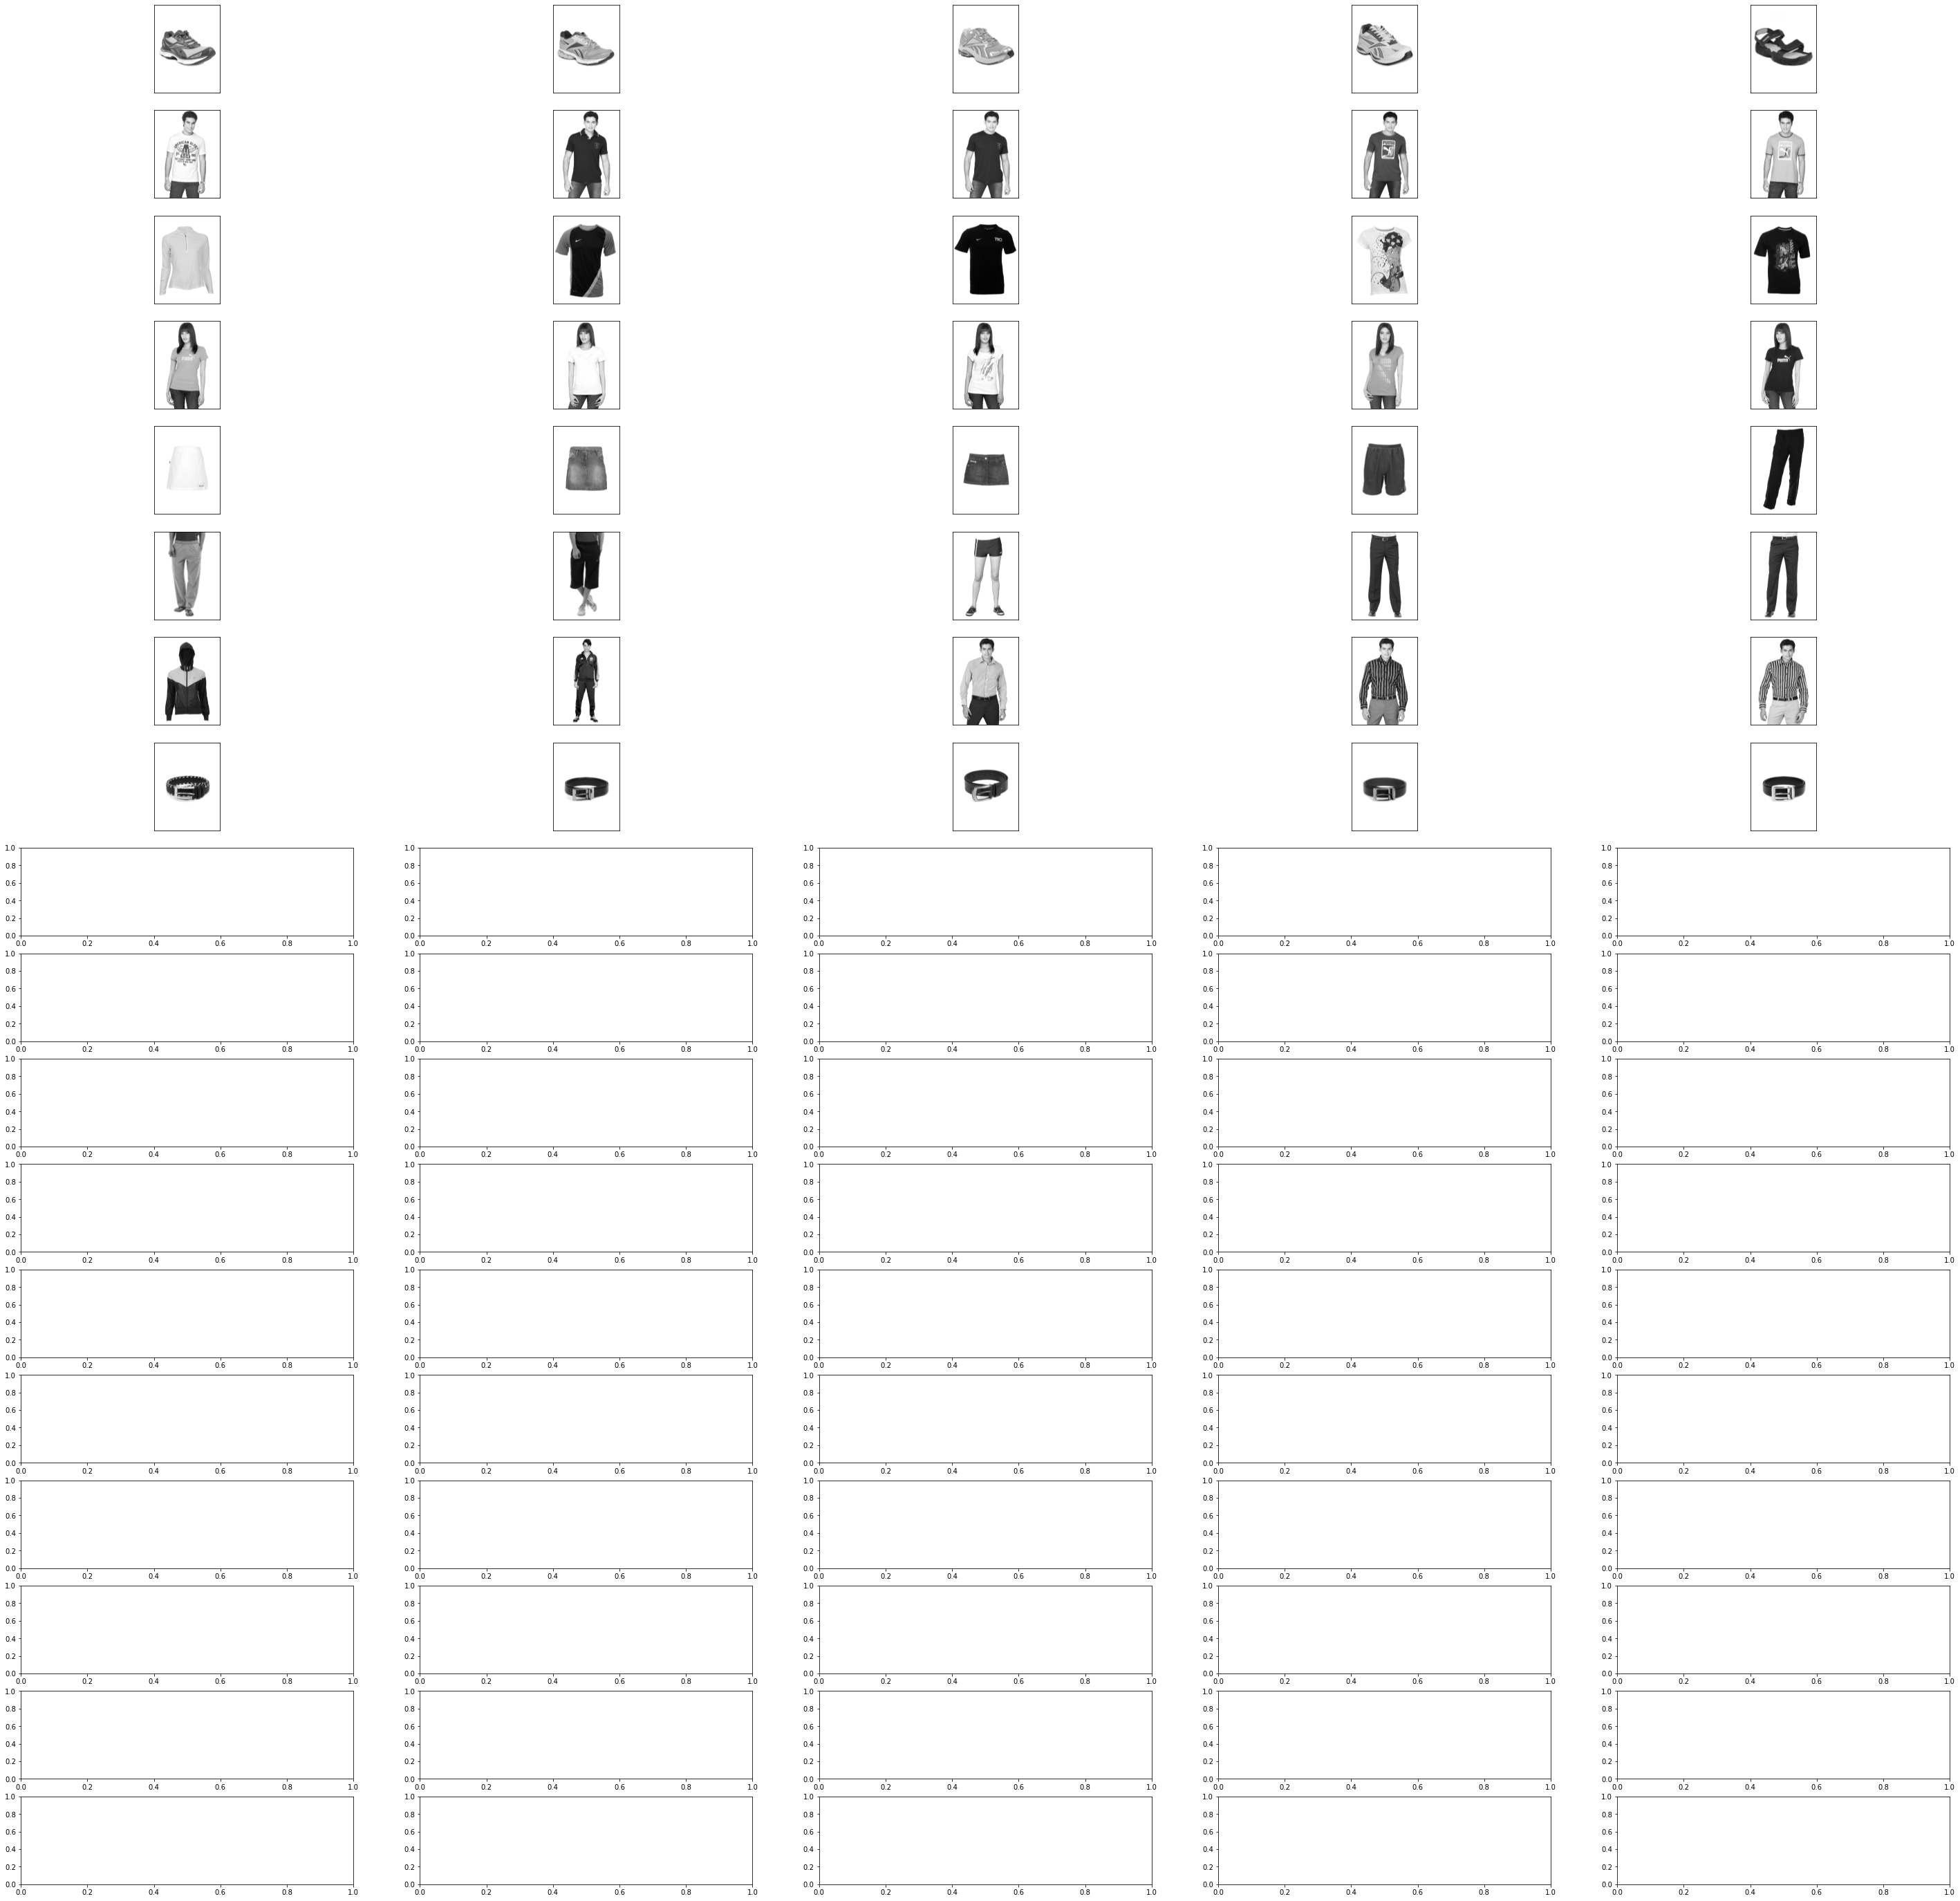

In [13]:
#Just to plot the cluster results to how well it performed.
# I created a figure with k rows and 5 columns
fig, axs = plt.subplots(k, 5, figsize=(50, 50))

# Then Loop over each cluster
for i in range(k):
    cluster_path = f"./cluster{i}/*.jpg"
    images = [cv2.imread(img_path, 0) for img_path in glob.glob(cluster_path)]

    # Loop over the first 5 images in the cluster
    for j, img in enumerate(images[:5]):
        axs[i, j].imshow(img, cmap='gray', interpolation='bicubic') # Display the image in the corresponding subplot
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


In [14]:
# Evaluate the model's effectiveness
silhouette_avg = silhouette_score(embeddings, cluster_labels)

print(f"Number of Clusters: {k}")
print(f"Silhouette Score: {silhouette_avg}")

Number of Clusters: 18
Silhouette Score: 0.07791227102279663


In [15]:
# Create the 'Clusters' folder if it doesn't exist
output_folder = 'Clusters'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List the cluster folders
cluster_folders = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']

# Copy the cluster folders into the 'Clusters' folder
for cluster_folder in cluster_folders:
    src_folder = cluster_folder
    dst_folder = os.path.join(output_folder, cluster_folder)
    shutil.copytree(src_folder, dst_folder)

print("Cluster folders copied successfully.")

Cluster folders copied successfully.


In [16]:
#Putting the dataset into a folder 
dataset_path = os.listdir('Clusters')
print(dataset_path)
print('Number of Classes:', (len(dataset_path)))

['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']
Number of Classes: 8


In [17]:
# To resize the images in the clusters image folder
# This is to make the images comform to EfficientNetB0 which only accepts 224, 224 size images.
# Read and resize images from selected files
dataset_path = 'Clusters'

# Define the target size for resizing
target_size = (224, 224)

# Define the normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Iterate over the folders inside the 'Clusters' folder
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        # Resize and normalize the images within each folder
        image_paths = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png'))
        for image_path in image_paths:
            img = Image.open(image_path)
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize the image by dividing by 255
            img = (img - mean) / std  # Normalize the image using mean and standard deviation
            img = img.astype(np.float32)
            img = np.transpose(img, (2, 0, 1))  # Convert image to channel-first format (C, H, W)

            # Save the resized and normalized image back to the same path
            #img = Image.fromarray(np.uint8(img * 255))
            #img.save(image_path)

print("Images resized and normalized successfully.")


Images resized and normalized successfully.


In [2]:


data_dir = 'Clusters'
batch_size = 1
img_height = 224
img_width = 224

# Create a training dataset from the directory containing image files
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create a validation dataset from the directory containing image files
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Split the validation dataset into validation and testing datasets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Print the class names for the training dataset
class_names = train_ds.class_names
print(class_names)


Found 10000 files belonging to 8 classes.
Using 8000 files for training.
Found 10000 files belonging to 8 classes.
Using 2000 files for validation.
['beltnothers', 'corporates', 'poloshirts', 'shoes', 'shorts', 'skirts', 'tshirts', 'womendress']


In [3]:
#define constant 'AUTOTUNE' which is used to dynamically tune the image buffer size
AUTOTUNE = tf.data.AUTOTUNE
#I Apply caching, shuffling and prefetching to the training dataset to optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#I Apply caching and prefetching to the validation dataset to optimize performance
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# Create a normalization layer with a rescaling factor of 1./255.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Map the normalization layer to each image in the train_ds dataset using the map() function
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Get the first image and its corresponding label from the normalized dataset using the iter() and next() functions
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image after normalization then set the number of classes to 8
print(np.min(first_image), np.max(first_image))
num_classes = 8

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.007002767 1.0


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

# Load the EfficientNetB0 model
model = EfficientNetB0(weights='imagenet')
#model.add(layers.Dense(units=7, activation='softmax'))
# # Create a data generator
# data_generator = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # Load the training dataset
# train_ds = data_generator.flow_from_directory(
#     data_dir,
#     target_size=(224, 224),
#     batch_size=1,
#     class_mode='categorical'
# )

# Compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [6]:
tf.data.experimental.enable_debug_mode()

# fitting the CNN model to the training dataset, train the model for 50 epochs, 
# and use the validation dataset for evaluating the model after each epoch 

epochs = 10

# Fit the model with validation data
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

Epoch 1/10
8000/8000 [==============================] - 4957s 610ms/step - loss: 0.4184 - accuracy: 0.8564 - val_loss: 5.4085 - val_accuracy: 0.4560
Epoch 2/10
8000/8000 [==============================] - 5989s 749ms/step - loss: 0.2503 - accuracy: 0.9159 - val_loss: 6.2710 - val_accuracy: 0.3890
Epoch 3/10
8000/8000 [==============================] - 5823s 728ms/step - loss: 0.2044 - accuracy: 0.9284 - val_loss: 13.5498 - val_accuracy: 0.2710
Epoch 4/10
8000/8000 [==============================] - 5527s 691ms/step - loss: 0.1797 - accuracy: 0.9396 - val_loss: 7.5464 - val_accuracy: 0.3970
Epoch 5/10
8000/8000 [==============================] - 5438s 680ms/step - loss: 0.1567 - accuracy: 0.9452 - val_loss: 7.0487 - val_accuracy: 0.3740
Epoch 6/10
8000/8000 [==============================] - 7148s 894ms/step - loss: 0.1407 - accuracy: 0.9494 - val_loss: 5.8325 - val_accuracy: 0.5340
Epoch 7/10
8000/8000 [==============================] - 6418s 802ms/step - loss: 0.1127 - accuracy: 0.957

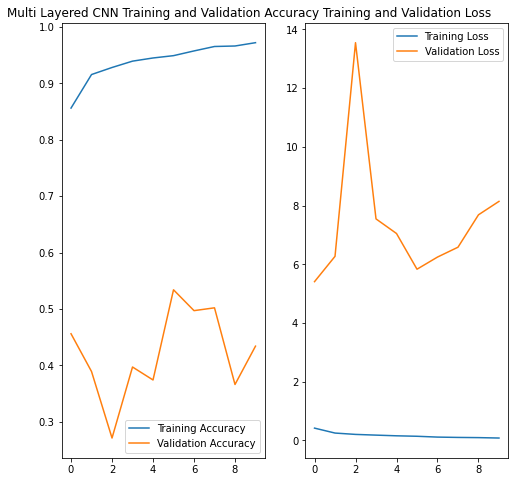

In [7]:
#Plotting the training and validation accuracy

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) # Here is the first subplot

# plot the training accuracy and validation accuracy over the epochs
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Add legend to the plot and place at the lower right corner
plt.legend(loc='lower right')
plt.title('Multi Layered CNN Training and Validation Accuracy')


plt.subplot(1, 2, 2) # Second subplot

# plot the training accuracy and validation loss over the epochs
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add legend to the plot and place at the upper right corner
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('Multi Layered CNN Training and Validation Loss')
plt.show()

(1, 224, 224, 3)
(1,)


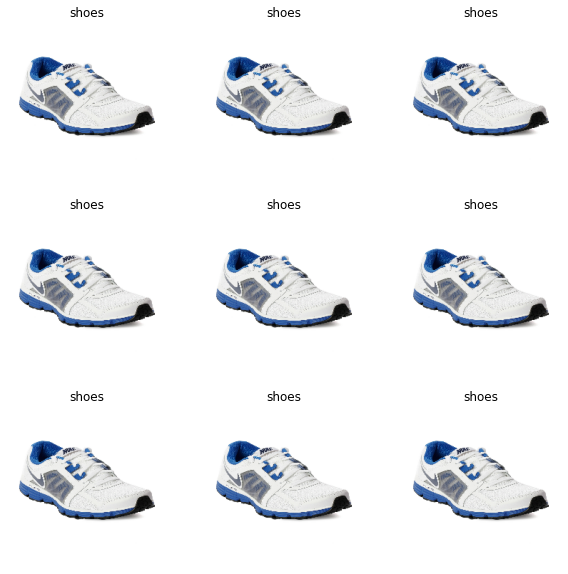

In [8]:
#Plotting sample predicted images to validate our model

# Create a 10x10 plot
plt.figure(figsize=(10, 10))
# Iterate through the first batch of the training dataset
for images, labels in train_ds.take(5):
    # Plot the first 9 images and their labels
 for i in range(9):
    # Set the subplot for the current image
     ax = plt.subplot(3, 3, i + 1)
    # Display the current image
     plt.imshow(images[0].numpy().astype("uint8"))
    # Set the title for the current image as its label
     plt.title(class_names[labels[0]])
    # Remove the axis of the plot
     plt.axis("off")

# Iterate through the training dataset and print the shape of each batch and its labels
for image_batch, labels_batch in train_ds:
     print(image_batch.shape)
     print(labels_batch.shape)
     break

1000/1000 [==============================] - 303s 241ms/step


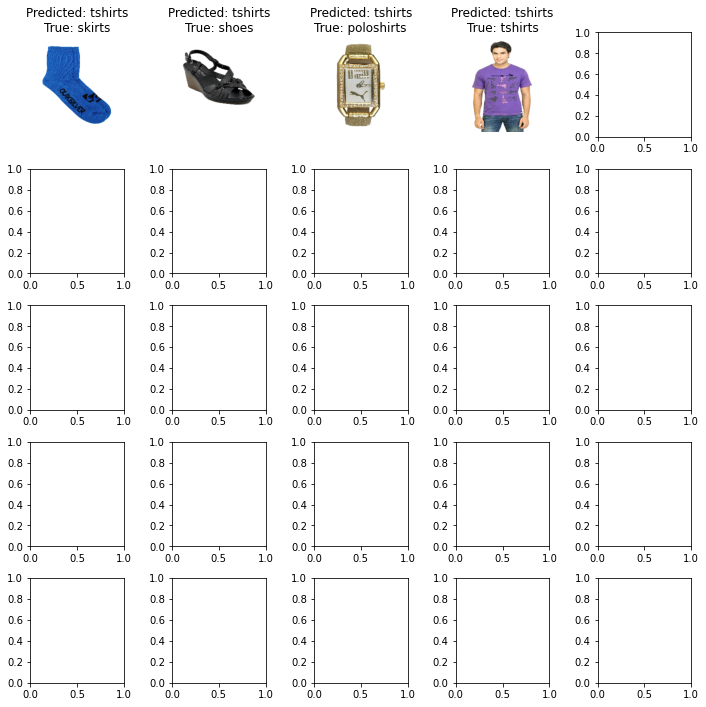

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Make predictions on the test dataset
y_pred = model.predict(test_ds)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Iterate over the test dataset and visualize the predicted images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, label) in enumerate(test_ds.take(4)):
    ax = axs[i // 5, i % 5]
    ax.imshow(image[0].numpy().astype("uint8"))
    ax.axis("off")
    ax.set_title(f"Predicted: {class_names[y_pred_labels[0]]}\nTrue: {class_names[label[0]]}")
plt.tight_layout()
plt.show()


In [10]:
# Here I am evaluating the model on the predicted images
# This is to determine how well it performs

# Convert the true labels of the test dataset to an array
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the evaluation metrics
accuracy = accuracy_score(true_labels, y_pred_labels)
precision = precision_score(true_labels, y_pred_labels, average='weighted')
recall = recall_score(true_labels, y_pred_labels, average='weighted')
f1 = f1_score(true_labels, y_pred_labels, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.116
Precision: 0.16484184838970367
Recall: 0.116
F1 Score: 0.1253412563996259


C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# To predict similar images using all the EfficientNet models and visualize the predicted images

In [1]:
# Importing all the required libraries

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import random

In [5]:

# I Define the list of EfficientNet models with their corresponding input sizes
models = [
    (EfficientNetB1, 240),
    (EfficientNetB2, 260),
    (EfficientNetB3, 300),
    (EfficientNetB4, 380),
    (EfficientNetB5, 456),
    (EfficientNetB6, 528),
    (EfficientNetB7, 600)
]

# I created a Custom progress function to show when the folder has been copied
def progress(current, total):
    progress_percent = (current / total) * 100
    print(f"Progress: {current}/{total} files ({progress_percent:.2f}%)")

# Specifying the source folder path
source_folder = 'Clusters'

# Specifying the destination folder path
# Set it to the path which represent the folder containing the data
data_folder = 'Clusters_Copy'

# Count the total number of files in the source folder
total_files = sum(len(files) for _, _, files in os.walk(source_folder))

# Copy the folder from source to destination with progress tracking
shutil.copytree(source_folder, data_folder, copy_function=shutil.copy2, symlinks=False, ignore=None, dirs_exist_ok=True)

print('Folder copied successfully')

train_ratio = 0.8  # Ratio of data to use for training

# Create the subfolders for training, testing, and validation
train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')
valid_folder = os.path.join(data_folder, 'validate')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)



Folder copied successfully


In [8]:
# Get the list of image files in the data folder
image_files = [file for file in os.listdir(data_folder)]

# Shuffle the image files
random.shuffle(image_files)

# Split the data into training, testing, and validation sets
train_size = int(len(image_files) * train_ratio)
test_size = (len(image_files) - train_size) // 2

train_files = image_files[:train_size]
test_files = image_files[train_size:train_size+test_size]
valid_files = image_files[train_size+test_size:]

# Move the files to the respective subfolders
for file in train_files:
    source = os.path.join(data_folder, file)
    destination = os.path.join(train_folder, file)
    #os.rename(source, destination)

for file in test_files:
    source = os.path.join(data_folder, file)
    destination = os.path.join(test_folder, file)
    #os.rename(source, destination)

for file in valid_files:
    source = os.path.join(data_folder, file)
    destination = os.path.join(valid_folder, file)
    #os.rename(source, destination)



# # Create a training dataset from the directory containing image files
# train_folder = tf.keras.preprocessing.image_dataset_from_directory(
#     data_folder,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# # Create a validation dataset from the directory containing image files
# valid_folder = tf.keras.preprocessing.image_dataset_from_directory(
#     data_folder,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# # Split the validation dataset into validation and testing datasets
# val_batches = tf.data.experimental.cardinality(valid_folder)
# test_folder = val_ds.take(val_batches // 2)
# valid_folder = val_ds.skip(val_batches // 2)

# Print the class names for the training dataset
# class_names = train_folder.class_names
# print(class_names)

In [9]:
# Loop through each EfficientNet model
for i, (model_type, input_size) in enumerate(models):
    print(f"Model: EfficientNetB{i+1}")
    print("============================")

    # Load the pre-trained model weights
    model = model_type(weights='imagenet', include_top=False, input_shape=(input_size, input_size, 3))

    # Define the data generators for training, testing, and validation
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

    train_generator = train_datagen.flow_from_directory(train_folder, target_size=(input_size, input_size), batch_size=32, class_mode='categorical')
    test_generator = test_datagen.flow_from_directory(test_folder, target_size=(input_size, input_size), batch_size=32, class_mode='categorical', shuffle=False)
    valid_generator = valid_datagen.flow_from_directory(valid_folder, target_size=(input_size, input_size), batch_size=32, class_mode='categorical')

   


Model: EfficientNetB1
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB2
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB3
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB4
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB5
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB6
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Model: EfficientNetB7
Found 5149 images belonging to 5 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [10]:
 # Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=valid_generator)

# Make predictions on the test set
predictions = model.predict(test_generator)

# Process the predictions and print the output
top_predictions = tf.keras.applications.efficientnet.decode_predictions(predictions, top=3)
for i, pred in enumerate(top_predictions):
    print(f"Image: {test_generator.filenames[i]}")
    print("Predictions:")
    for p in pred:
        print(f"{p[1]}: {p[2]*100:.2f}%")
    print()

print("\n")

Epoch 1/10


ValueError: in user code:

    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\admin\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 19, 19, 2560) are incompatible
